## map2loop: Topology fom Local file or Loop WFS Server
This notebook reads in two layers from the local files:  geology polygons and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

In [1]:
import subprocess
import geopandas as gpd
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
from shapely.geometry import Polygon
from map2loop import m2l_utils
%matplotlib inline

newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
test_data_path='../test_data3/'


%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from m2l_config.py:
#ROI
minlong=117 # should back calc from metre system\n",
maxlong=118
minlat=-23
maxlat=-22

step_out=0
inset=0

minx=500057
maxx=603028
miny=7455348
maxy=7567953

#CRS
src_crs = {'init': 'EPSG:4326'}  
dst_crs = {'init': 'EPSG:28350'} 

#PATH
mname='hams3'
geology_file='hams2_geol.shp'
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp'
structure_file='hams2_structure.shp'



#CODES
gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'
ncode='NAME'
ocode='OBJECTID'
gicode='GEOPNT_ID'
r1code='ROCKTYPE1'
r2code='ROCKTYPE2'
tcode='TYPE'
fcode='FEATURE'
dscode='DESCRIPTN'
ucode='UNITNAME'
mincode='MIN_AGE_MA'
maxcode='MAX_AGE_MA'
sill_label='sill'
intrusive_label='intrusive'
fold_label='Fold axial trace'
fault_label='Fault'
bedding_label='Bed'

#MODEL_EXTENTS
model_base=-8200


#DECIMATION
orientation_decimate=0
contact_decimate=10
fault_decimate=5
fold_decimate=5


#INTERPOLATION
gridx=25
gridy=25
scheme='scipy_rbf'
dist_buffer=5
intrus

## First we test to see if we have access to the online data we need


In [3]:
net=m2l_utils.have_access("geo.loop-gis.org")


available: geo.loop-gis.org


## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [4]:
local_paths=True



if(not local_paths and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    gcode='group_'
    dcode='dip'
    ddcode='dip_dir'
    ccode='code'
    ncode='fname'
    ocode='objectid'
    gicode='geopnt_id'
    r1code='rocktype1'
    r2code='rocktype2'
    tcode='type'
    fcode='feature'
    dscode='descriptn'
    ucode='unitname'
    mincode='min_age_ma'
    maxcode='max_age_ma'

## Plot geology polygons and bounding box

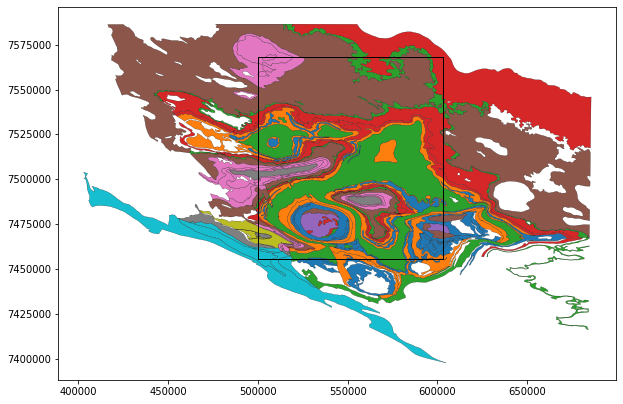

In [5]:
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=ccode,figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save to file as WKT

In [6]:
sub_geol = geology_ll[['geometry', ocode,ccode,gcode,ucode,mincode,maxcode,dscode,r1code,r2code]]

In [7]:
f= open(geology_file_csv,"w+")
f.write('WKT\t'+ocode+'\t'+ucode+'\t'+gcode+'\t'+mincode+'\t'+maxcode+'\t'+ccode+'\t'+r1code+'\t'+r2code+'\t'+dscode+'\n')
#display(sub_geol)        
print(len(sub_geol)," polygons")
#print(sub_geol)
for i in range(0,len(sub_geol)):
    f.write("\""+str(sub_geol.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_geol.loc[i][ocode])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][ccode])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][gcode]).replace("None","")+"\"\t") #since map2model is looking for "" not "None"
    f.write("\""+str(sub_geol.loc[i][mincode])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][maxcode])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][ucode])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][r1code])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][r2code])+"\"\t")
    f.write("\""+str(sub_geol.loc[i][dscode])+"\"\n")
    
f.close()

186  polygons


## Read and save WAROX point data as WKT

121  points


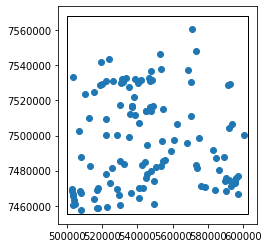

In [8]:
warox = gpd.read_file(structure_file,bbox=bbox)


sub_pts = warox[['geometry', gicode,dcode,ddcode]]

f= open(structure_file_csv,"w+")
f.write('WKT\t'+gicode+'\t'+dcode+'\t'+ddcode+'\n')

print(len(sub_pts)," points")


#for i in range(0,len(sub_pts)):
#    for j in range(0,len(sub_geol)):
#        if(sub_pts.loc[i].geometry.within(sub_geol.loc[j].geometry)):
#            print(i,j)

for i in range(0,len(sub_pts)):
    line="\""+str(sub_pts.loc[i].geometry)+"\"\t\""+str(sub_pts.loc[i][gicode])+"\"\t\""+\
      str(sub_pts.loc[i][dcode])+"\"\t\""+str(sub_pts.loc[i][ddcode])+"\"\n"    
    f.write(functools.reduce(operator.add, (line)))
    
f.close()

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

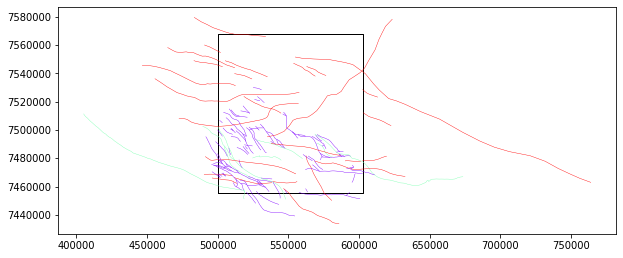

In [9]:
#bbox='-23,117,-22,118'
#lines=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology_structural_lines__DMIRS-013_&BBOX="+bbox+"&srs=EPSG:3857")
#print(lines)
#lines.plot(column='feature',figsize=(10,10),linewidth=0.2)
lines_ll=gpd.read_file(fault_file,bbox=bbox)
#lines_ll = lines.to_crs('epsg:4326')
#print(geology.crs)
base2=lines_ll.plot(cmap='rainbow',column=fcode,figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [10]:
sub_lines = lines_ll[['geometry', ocode,fcode]]

f= open(fault_file_csv,"w+")
f.write('WKT\t'+ocode+'\t'+fcode+'\n')

print(len(sub_lines)," polylines")

for i in range(0,len(sub_lines)):
    if('Fault' in sub_lines.loc[i][fcode]):
        f.write("\""+str(sub_lines.loc[i].geometry)+"\"\t")
        f.write("\""+str(sub_lines.loc[i][ocode])+"\"\t")
        f.write("\""+str(sub_lines.loc[i][fcode])+"\"\n")
    
f.close()

134  polylines


## Create map2model input file

In [11]:
f=open(m2m_cpp_path+'Parfile','w')
f.write('--- COLUMN NAMES IN CSV DATA FILES: -------------------------------------------------------------\n')
f.write('OBJECT COORDINATES              =WKT\n')
f.write('FAULT: ID                       ='+ocode+'\n')
f.write('FAULT: FEATURE                  ='+fcode+'\n')
f.write('POINT: ID                       ='+gicode+'\n')
f.write('POINT: DIP                      ='+dcode+'\n')
f.write('POINT: DIP DIR                  ='+ddcode+'\n')
f.write('POLYGON: ID                     ='+ocode+'\n')
f.write('POLYGON: LEVEL1 NAME            ='+ucode+'\n')
f.write('POLYGON: LEVEL2 NAME            ='+gcode+'\n')
f.write('POLYGON: MIN AGE                ='+mincode+'\n')
f.write('POLYGON: MAX AGE                ='+maxcode+'\n')
f.write('POLYGON: CODE                   ='+ccode+'\n')
f.write('POLYGON: DESCRIPTION            ='+dscode+'\n')
f.write('POLYGON: ROCKTYPE1              ='+r1code+'\n')
f.write('POLYGON: ROCKTYPE2              ='+r2code+'\n')
f.write('--- SOME CONSTANTS: ----------------------------------------------------------------------------\n')
f.write('FAULT AXIAL FEATURE NAME        ='+fold_label+'\n')
f.write('SILL UNIT DESCRIPTION CONTAINS  ='+sill_label+'\n')
f.write('------------------------------------------------------------------------------------------------\n')
f.write('Path to the output data folder                      ='+graph_path+'\n')
f.write('Path to geology data file                           ='+geology_file_csv+'\n')
f.write('Path to faults data file                            ='+fault_file_csv+'\n')
f.write('Path to points data file                            ='+structure_file_csv+'\n')
f.write('------------------------------------------------------------------------------------------------\n')
f.write('Clipping window X1 Y1 X2 Y2 (zeros for infinite)    ='+str(minx)+' '+str(miny)+' '+str(maxx)+' '+str(maxy)+'\n')
f.write('Min length fraction for strat/fault graphs          =0.0\n')
f.write('Graph edge width categories (three doubles)         =2000. 20000. 200000.\n')
f.write('Graph edge direction (0-min age, 1-max age, 2-avg)  =2\n')
f.write('Partial graph polygon ID                            =32\n')
f.write('Partial graph depth                                 =4\n')
f.write('Map subregion size dx, dy [m] (zeros for full map)  =0. 0.\n')
f.write('------------------------------------------------------------------------------------------------\n')
f.close()



## Calculate topology

In [12]:
os.chdir(m2m_cpp_path)
print(os.getcwd())
%system map2model.exe Parfile

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


['Reading data from the file: Parfile',
 '--- COLUMN NAMES IN CSV DATA FILES: -------------------------------------------------------------',
 'OBJECT COORDINATES              =WKT',
 'FAULT: ID                       =OBJECTID',
 'FAULT: FEATURE                  =FEATURE',
 'POINT: ID                       =GEOPNT_ID',
 'POINT: DIP                      =DIP',
 'POINT: DIP DIR                  =DIP_DIR',
 'POLYGON: ID                     =OBJECTID',
 'POLYGON: LEVEL1 NAME            =UNITNAME',
 'POLYGON: LEVEL2 NAME            =GROUP_',
 'POLYGON: MIN AGE                =MIN_AGE_MA',
 'POLYGON: MAX AGE                =MAX_AGE_MA',
 'POLYGON: CODE                   =CODE',
 'POLYGON: DESCRIPTION            =DESCRIPTN',
 'POLYGON: ROCKTYPE1              =ROCKTYPE1',
 'POLYGON: ROCKTYPE2              =ROCKTYPE2',
 '--- SOME CONSTANTS: ----------------------------------------------------------------------------',
 'FAULT AXIAL FEATURE NAME        =Fold axial trace',
 'SILL UNIT DESCRIPTION

## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'A-HAm-cib'
1    'A-FOp-bs'
2    'A-HAS-xsl-ci'
3    'P_-HAb-cib'
4    'P_-HAj-xci-od'
5    'A-mgn-PRK'
6    'A-FOh-xs-f'
7    'A-FOo-bbo'
8    'A-FO-od'
9    'A-HAd-kd'
10    'A-FOj-xs-b'
11    'P_-TKa-xs-k'
12    'P_-HAo-ci'
13    'P_-HAw-fr'
14    'A-FO-xo-a'
15    'A-b-PRK'
16    'A-FOr-b'
17    'A-FOu-bbo'
18    'P_-TK-s'
19    'A-mgn-PMI'
20    'A-s-PMI'
21    'A-s-PRK'
22    'P_-SKq-stq'
23    'P_-WYm-sp'
24    'P_-WYa-st'
25    'P_-WYd-kd'
26    'P_-TKo-stq'
27    'P_-TKk-sf'
28    'P_-SKb-bb'


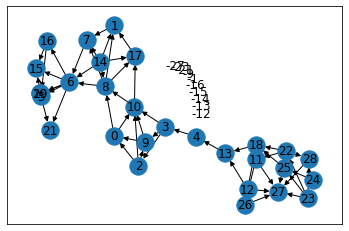

In [13]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb

# map2loop: Process topography, stratigraphy, fold axial traces and faults

## Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [14]:
import os
#print(os.getcwd())
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [15]:
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry

m2l_utils.v()

0.0.46


In [16]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
import geopandas as gpd
import os
from shapely.geometry import Polygon, Point, LineString
sys.path.insert(0,"../..")
print(os.getcwd())
#rootdir=r'C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\\'
#os.chdir('../')
print(os.getcwd())
os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## First we test to see if we have access to the online data we need


In [17]:
m2l_utils.have_access("oos.soest.hawaii.edu")
net=m2l_utils.have_access("geo.loop-gis.org")


available: oos.soest.hawaii.edu
available: geo.loop-gis.org


## Next we define an area of interest and some other basic stuff

In [18]:
print(os.getcwd())
test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


contact_decimate=5

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [19]:
if(not local_paths and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    gcode='group_'
    dcode='dip'
    ddcode='dip_dir'
    ccode='code'
    ncode='fname'
    ocode='objectid'
    gicode='geopnt_id'
    r1code='rocktype1'
    r2code='rocktype2'
    tcode='type'
    fcode='feature'
    dscode='descriptn'
    ucode='unitname'
    mincode='min_age_ma'
    maxcode='max_age_ma'

## Download and reproject the appropriate SRTM data
mj: Getting this from Hawaii, but could also get from Geoscience Australia (expect when I tried via WCS it blew up for more than 0.25 degree square areas, but I am pretty sure this is a OWS python plugin problem not GA since I can load the whole data with QGIS)

In [20]:
m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat,step_out)
geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



dtm geotif saved as ../test_data3/dtm/hams3_dtm.tif
reprojected dtm geotif saved as ../test_data3/dtm/hams3_dtm_rp.tif


## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.


-12 A_b_PRK ----------------------
choices: 1
15 A_b_PRK

-13 A_mgn_PMI ----------------------
choices: 1
19 A_mgn_PMI

-14 A_mgn_PRK ----------------------
choices: 1
5 A_mgn_PRK

-15 A_s_PMI ----------------------
choices: 1
20 A_s_PMI

-16 A_s_PRK ----------------------
choices: 1
21 A_s_PRK

-1 Fortescue_Group ----------------------
choices: 2
10 A_FOj_xs_b
14 A_FO_xo_a
8 A_FO_od
17 A_FOu_bbo
1 A_FOp_bs
7 A_FOo_bbo
6 A_FOh_xs_f
16 A_FOr_b
....
14 A_FO_xo_a
10 A_FOj_xs_b
8 A_FO_od
17 A_FOu_bbo
1 A_FOp_bs
7 A_FOo_bbo
6 A_FOh_xs_f
16 A_FOr_b

-9 Hamersley_Group ----------------------


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


choices: 1
12 P__HAo_ci
13 P__HAw_fr
4 P__HAj_xci_od
3 P__HAb_cib
2 A_HAS_xsl_ci
9 A_HAd_kd
0 A_HAm_cib

-21 Shingle_Creek_Group ----------------------
choices: 1
22 P__SKq_stq
28 P__SKb_bb

-23 Turee_Creek_Group ----------------------
choices: 4
11 P__TKa_xs_k
26 P__TKo_stq
27 P__TKk_sf
18 P__TK_s
....
11 P__TKa_xs_k
26 P__TKo_stq
18 P__TK_s
27 P__TKk_sf
....
11 P__TKa_xs_k
18 P__TK_s
26 P__TKo_stq
27 P__TKk_sf
....
18 P__TK_s
11 P__TKa_xs_k
26 P__TKo_stq
27 P__TKk_sf

-27 Wyloo_Group ----------------------
choices: 2
23 P__WYm_sp
24 P__WYa_st
25 P__WYd_kd
....
24 P__WYa_st
23 P__WYm_sp
25 P__WYd_kd


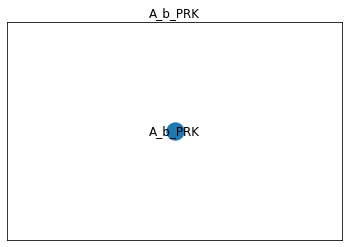

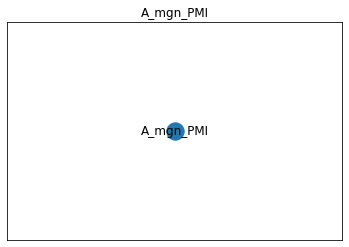

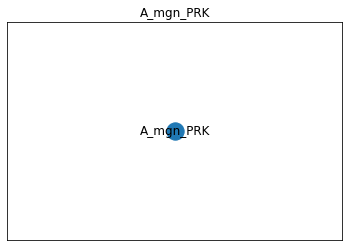

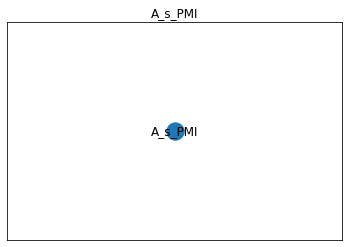

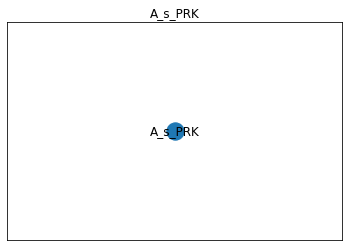

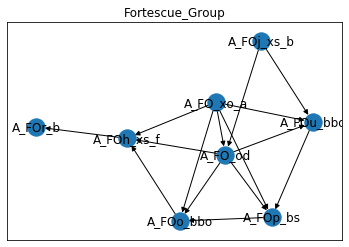

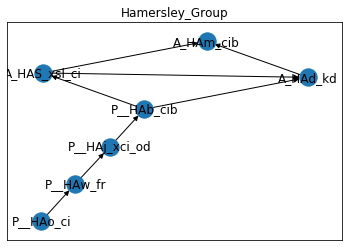

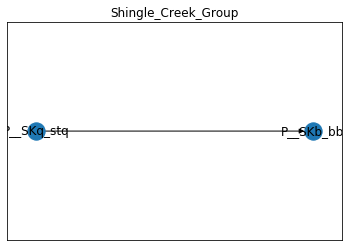

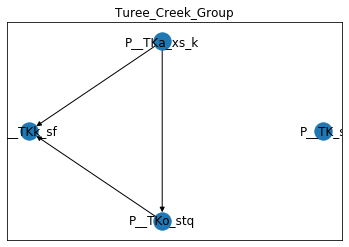

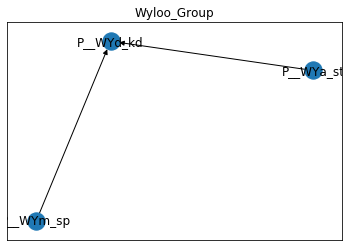

In [21]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../test_data3/data/GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp


,OBJECTID,FEATURE,TYPE,NAME,CODE,DIP,DIP_EST,DIP_DIR,PLUNGE,PLUNGE_EST,PLUNGE_DIR,MAX_AGE_EV,MIN_AGE_EV,SYMBOL,EXTRACT_DA,Shape_Leng,geometry
0,313,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.170901,LINESTRING (521647.7793438953 7467241.05086821...
1,813,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.025914,LINESTRING (507220.4879050475 7474402.80112244...
2,815,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.082161,LINESTRING (503666.6180891695 7475968.74187633...
3,958,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.103595,LINESTRING (505827.131279325 7474276.742161302...
4,961,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.042289,LINESTRING (589818.4508883164 7481426.91119014...
5,962,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.027184,LINESTRING (520020.6948380488 7495438.93368950...
6,1236,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.058439,LINESTRING (569405.4426076568 7496423.33170704...
7,2225,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.013465,LINESTRING (505810.4087035206 7467238.60820810...
8,2227,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.017688,LINESTRING (504330.2140857202 7468391.18745571...
9,2229,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.058889,LINESTRING (517573.9744097722 7473125.01394264...


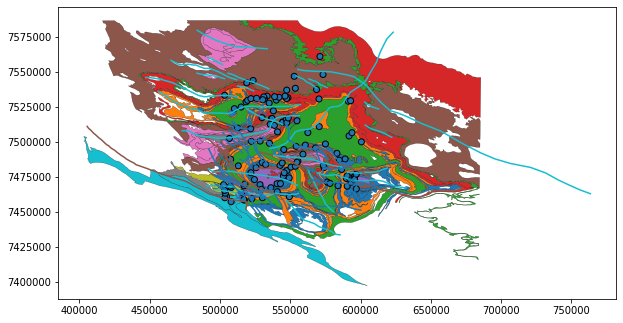

In [22]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
display(faults)
sub_pts = structure[['geometry',dcode,ddcode,fcode]]

base=geology.plot(column=ccode,figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base, column=fcode,edgecolor='black')
faults.plot(ax=base, column=fcode,edgecolor='black')

## Clip geology, faults, structures and map geology to structures

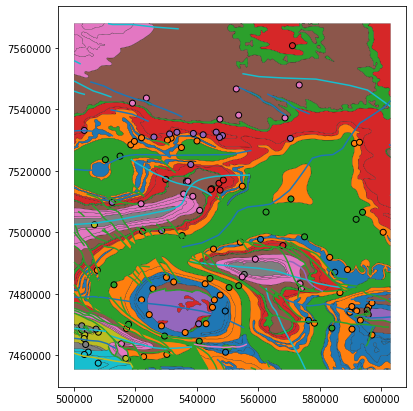

In [23]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 

if(local_paths):
     is_bed=structure_code.FEATURE.str.contains(bedding_label, regex=False) #hardwires, needs if of local
else:
     is_bed=structure_code.feature.str.contains(bedding_label, regex=False) #hardwires, needs if of local
    
all_beds = structure_code[is_bed]

geol_clip=m2l_utils.clip_shp(geology, polygo)
faults_clip=m2l_utils.clip_shp(faults,polygo)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=ccode,figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=tcode,edgecolor='black')
structure_clip.plot(ax=base, column=ccode,edgecolor='black')

geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,group_,min,max,ave
0,0,Wyloo_Group,1799.0,2010.0,1904.5
1,1,Shingle_Creek_Group,2208.0,2208.0,2208.0
2,2,Turee_Creek_Group,2208.0,2449.0,2328.5
3,3,Hamersley_Group,2208.0,2629.0,2418.5
4,4,Fortescue_Group,2629.0,2780.0,2704.5
5,5,A_mgn_PMI,2830.0,3500.0,3165.0
6,6,A_mgn_PRK,2830.0,3500.0,3165.0
7,7,A_s_PMI,2930.0,3520.0,3225.0
8,8,A_b_PRK,2930.0,3520.0,3225.0
9,9,A_s_PRK,2930.0,3520.0,3225.0


,index,min,max,ave
group_,,,,
Wyloo_Group,0,1799.0,2010.0,1904.5
Shingle_Creek_Group,1,2208.0,2208.0,2208.0
Turee_Creek_Group,2,2208.0,2449.0,2328.5
Hamersley_Group,3,2208.0,2629.0,2418.5
Fortescue_Group,4,2629.0,2780.0,2704.5
A_mgn_PMI,5,2830.0,3500.0,3165.0
A_mgn_PRK,6,2830.0,3500.0,3165.0
A_s_PMI,7,2930.0,3520.0,3225.0
A_b_PRK,8,2930.0,3520.0,3225.0


[]

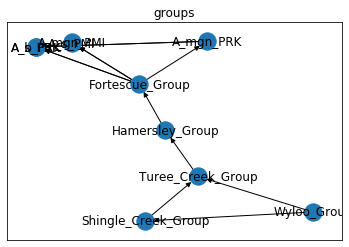

P__WYm_sp
P__WYa_st
P__WYd_kd
P__SKq_stq
P__SKb_bb
P__TKa_xs_k
P__TKo_stq
P__TKk_sf
P__TK_s
P__HAo_ci
P__HAw_fr
P__HAj_xci_od
P__HAb_cib
A_HAS_xsl_ci
A_HAd_kd
A_HAm_cib
A_FOj_xs_b
A_FO_xo_a
A_FO_od
A_FOu_bbo
A_FOp_bs
A_FOo_bbo
A_FOh_xs_f
A_FOr_b
A_s_PMI
A_mgn_PMI
A_mgn_PRK
A_s_PRK
A_b_PRK


In [24]:
m2l_topology.save_group(G,mname,tmp_path,glabels,geol_clip,ccode,gcode,mincode,maxcode)

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='../graphics/polarity.png'>

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [25]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_code,mname,output_path,ddcode,dcode,ccode,r1code,intrusive_label,orientation_decimate,dtm)


115 orientations saved to ../test_data3/output//hams3_orientations.csv


## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

Orientations----------
 10 [('Wyloo_Group', 1), ('Shingle_Creek_Group', 1), ('Turee_Creek_Group', 1), ('Hamersley_Group', 1), ('Fortescue_Group', 1), ('A_s_PMI', 1), ('A_mgn_PMI', 1), ('A_mgn_PRK', 0), ('A_s_PRK', 0), ('A_b_PRK', 1)]
Contacts----------
 29 {'A-FOu-bbo', 'P_-HAj-xci-od', 'A-HAd-kd', 'P_-SKq-stq', 'P_-SKb-bb', 'P_-HAo-ci', 'A-FOr-b', 'A-HAS-xsl-ci', 'A-FOo-bbo', 'A-s-PMI', 'A-mgn-PMI', 'P_-WYd-kd', 'P_-TKo-stq', 'P_-TKk-sf', 'A-FO-xo-a', 'A-b-PRK', 'P_-TK-s', 'A-HAm-cib', 'A-FO-od', 'A-s-PRK', 'P_-HAw-fr', 'P_-TKa-xs-k', 'A-mgn-PRK', 'A-FOp-bs', 'A-FOj-xs-b', 'A-FOh-xs-f', 'P_-WYm-sp', 'P_-WYa-st', 'P_-HAb-cib'}


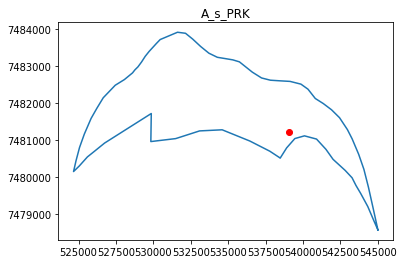

extra orientations saved as ../test_data3/output//hams3_empty_series_orientations.csv


In [26]:
m2l_geometry.create_orientations(mname, tmp_path, output_path, dtm,geol_clip,structure_clip,ccode,gcode,r1code,intrusive_label)

## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.

<font color='red'>Needs also to account for case when missing surface in stratigraphy means that locally basal polyline can ALSO be anothe rthan youngest surface.</font>
<img src='../graphics/base.png'>

In [27]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(mname,tmp_path,dtm,geol_clip,contact_decimate,ccode,gcode,ocode,dscode,r1code,intrusion_mode)

decimation: 1 / 5
surfaces: 30
polygons: 206
[[1, 'P__WYm_sp'], [2, 'P__WYa_st'], [3, 'P__WYd_kd'], [4, 'P__SKq_stq'], [5, 'P__SKb_bb'], [6, 'P__TKa_xs_k'], [7, 'P__TKo_stq'], [8, 'P__TKk_sf'], [9, 'P__TK_s'], [10, 'P__HAo_ci'], [11, 'P__HAw_fr'], [12, 'P__HAj_xci_od'], [13, 'P__HAb_cib'], [14, 'A_HAS_xsl_ci'], [15, 'A_HAd_kd'], [16, 'A_HAm_cib'], [17, 'A_FOj_xs_b'], [18, 'A_FO_xo_a'], [19, 'A_FO_od'], [20, 'A_FOu_bbo'], [21, 'A_FOp_bs'], [22, 'A_FOo_bbo'], [23, 'A_FOh_xs_f'], [24, 'A_FOr_b'], [25, 'A_s_PMI'], [26, 'A_mgn_PMI'], [27, 'A_mgn_PRK'], [28, 'A_s_PRK'], [29, 'A_b_PRK']]
BoundingBox(left=500000.0000000026, bottom=7454093.693147668, right=605065.852135498, top=7567173.042479938)
basal contacts saved allpts= 10789 deci_pts= 2573
saved as ../test_data3/tmp/hams3_all_contacts.csv and ../test_data3/tmp/hams3_contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [28]:
m2l_geometry.save_basal_no_faults(mname,tmp_path+'basal_contacts2.shp',tmp_path+'faults_clip.shp',ls_dict,10,ccode,gcode,dst_crs)

(211,)
basal contacts without faults saved as ../test_data3/tmp/basal_contacts2.shp


## Remove faults from decimated basal contacts as save as csv file

In [29]:
m2l_geometry.save_contacts_with_faults_removed(mname,tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,ccode,dst_crs,dtm)

undecimated points: 2573
2220 decimated contact points saved as ../test_data3/output//hams3_contacts4.csv


## Save fault as contact info and and orientation info make vertical (for the moment)

In [30]:
m2l_geometry.save_faults(mname,tmp_path+'faults_clip.shp',output_path,dtm,ncode,ocode,fcode,fault_decimate)

fault orientations saved as ../test_data3/output/hams3_fault_orientations.csv
fault positions saved as ../test_data3/output/hams3_faults.csv


## Create basal contact points with orientation from orientations and basal points

In [31]:
contacts = gpd.read_file(tmp_path+'basal_contacts2.shp') #load orientation data as geopandas dataframe 
structures = gpd.read_file(tmp_path+'structure_clip.shp') #load orientation data as geopandas dataframe 

m2l_geometry.create_basal_contact_orientations(mname,contacts,structures,output_path,dtm,2500,ccode,gcode,dcode,ddcode)


basal contact orientations saved as ../test_data3/output/hams3_projected_dip_contacts2.csv


## Creates fold axial trace points

In [32]:
m2l_geometry.save_fold_axial_traces(mname,tmp_path+'faults_clip.shp',output_path,dtm,ocode,tcode,fcode,fold_decimate)

fold axial traces saved as ../test_data3/output//hams3_fold_axial_traces.csv


# map2loop:  Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with three possible sub-surface configurations:

<b>saucers: \\_____/ <br>
pancakes: /_____\\   
domes: /‾\\</b>

Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>
Doesn't account for faults yet...

In [33]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
from map2loop import m2l_utils
import geopandas as gpd
import pandas as pd
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2
from shapely.geometry import shape, Polygon, LineString, Point
## import geopandas as gpd
#os.chdir('..')

print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [34]:
%run -i "../notebooks/m2l_config.py"
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10



Default parameters loaded from m2l_config.py:
#ROI
minlong=117 # should back calc from metre system\n",
maxlong=118
minlat=-23
maxlat=-22

step_out=0
inset=0

minx=500057
maxx=603028
miny=7455348
maxy=7567953

#CRS
src_crs = {'init': 'EPSG:4326'}  
dst_crs = {'init': 'EPSG:28350'} 

#PATH
mname='hams3'
geology_file='hams2_geol.shp'
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp'
structure_file='hams2_structure.shp'

test_data_path='../test_data3/'


#CODES
gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'
ncode='NAME'
ocode='OBJECTID'
gicode='GEOPNT_ID'
r1code='ROCKTYPE1'
r2code='ROCKTYPE2'
tcode='TYPE'
fcode='FEATURE'
dscode='DESCRIPTN'
ucode='UNITNAME'
mincode='MIN_AGE_MA'
maxcode='MAX_AGE_MA'
sill_label='sill'
intrusive_label='intrusive'
fold_label='Fold axial trace'
fault_label='Fault'
bedding_label='Bed'

#MODEL_EXTENTS
model_base=-8200


#DECIMATION
orientation_decimate=0
contact_decimate=25
fault_decimate=5
fold_decimate=5


#INTERPOLATION
gridx=100
gridy=100
schem

In [35]:
test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"


geology = gpd.read_file(data_path+'hams2_geol.shp',bbox=bbox)
print(geology.crs)

geol_explode=m2l_utils.explode(geology)
print(geology.shape, geol_explode.shape)
roi = gpd.read_file(data_path+'hamms_roi.shp')

geol_clip=m2l_utils.clip_shp(geol_explode,roi)


dtm_reproj_file=dtm_path+'hams3_dtm_rp.tif'

dtm = rasterio.open(dtm_reproj_file)

f=open(tmp_path+'hams3_groups.csv',"r")
groups =f.readlines()
f.close

ngroups=groups[0].split(" ")
ngroups=int(ngroups[1])

orig_ngroups=ngroups



{'init': 'epsg:28350'}
(186, 63) (186, 63)


if(not local_paths and net):
    gcode='group_'
    dcode='dip'
    ddcode='dip_dir'
    ccode='code'
    ncode='fname'
    ocode='objectid'
    gicode='geopnt_id'
    r1code='rocktype1'
    r2code='rocktype2'
    tcode='type'
    fcode='feature'
    dscode='descriptn'
    ucode='unitname'
    mincode='min_age_ma'
    maxcode='max_age_ma'

In [36]:
gp_ages=np.zeros((1000,3))
gp_names=np.zeros((1000),dtype='U25')

for i in range (0,ngroups):
    gp_ages[i,0]=-1e6 # group max_age
    gp_ages[i,1]=1e6 # group min_age
    gp_ages[i,2]=i # group index
    gp_names[i]=groups[i+1].replace("\n","")
    print(i,gp_names[i])

print(local_paths)  

0 Wyloo_Group
1 Shingle_Creek_Group
2 Turee_Creek_Group
3 Hamersley_Group
4 Fortescue_Group
5 A_s_PMI
6 A_mgn_PMI
7 A_mgn_PRK
8 A_s_PRK
9 A_b_PRK
False


In [37]:
allc=open(output_path+'all_ign_contacts.csv',"w")
allc.write('GROUP_,id,x,y,z,code\n')
ac=open(output_path+'ign_contacts.csv',"w")
ac.write("X,Y,Z,formation\n")
ao=open(output_path+'ign_orientations_'+pluton_form+'.csv',"w")
ao.write("X,Y,Z,azimuth,dip,polarity,formation\n")
print(output_path+'ign_orientations_'+pluton_form+'.csv')
j=0
allpts=0
ls_dict={}
ls_dict_decimate={}
id=0
for ageol in geol_clip.iterrows(): 
    ades=str(ageol[1][dscode])
    arck=str(ageol[1][r1code])
    if(str(ageol[1][gcode])=='None'):
        agroup=str(ageol[1][ccode])
    else:
        agroup=str(ageol[1][gcode])
    
    for i in range(0,ngroups):
        if (gp_names[i]==agroup):
            if(int(ageol[1][maxcode]) > gp_ages[i][0]  ):
                gp_ages[i][0] = ageol[1][maxcode]
                #print("max",agroup,gp_ages[i][0])
            if(int(ageol[1][mincode]) < gp_ages[i][1]  ):
                gp_ages[i][1] = ageol[1][mincode]
                #print("min",agroup,gp_ages[i][1])
    if(intrusive_label in arck and sill_label not in ades):
        newgp=str(ageol[1][ccode])+'_'+str(ageol[1][ocode])
        #agp=str(ageol[1][gcode])
        #print(newgp)
        if(str(ageol[1][gcode])=='None'):
            agp=str(ageol[1][ccode])
        else:
            agp=str(ageol[1][gcode])

        if(not newgp  in gp_names):
            #print("MMMMM",ngroups,newgp)
            gp_names[ngroups]=newgp
            gp_ages[ngroups][0]=ageol[1][maxcode]
            gp_ages[ngroups][1]=ageol[1][mincode]
            gp_ages[ngroups][2]=ngroups
            ngroups=ngroups+1
        #else:
            #print("-----",ngroups,newgp)
            
        neighbours=[]
        j+=1
        central_age=ageol[1][mincode]    #absolute age of central polygon
        central_poly=ageol[1].geometry
        for bgeol in geol_clip.iterrows(): #potential neighbouring polygons  
            if(ageol[1].geometry!=bgeol[1].geometry): #do not compare with self
                if (ageol[1].geometry.intersects(bgeol[1].geometry)): # is a neighbour
                    neighbours.append([(bgeol[1][ccode],bgeol[1][mincode],bgeol[1][r1code],bgeol[1][dscode],bgeol[1].geometry)])  
        #display(neighbours)
        if(len(neighbours) >0):
            for i in range (0,len(neighbours)):
                if((intrusive_label in neighbours[i][0][2] and sill_label not in ades) 
                   #or ('intrusive' not in neighbours[i][0][2]) and neighbours[i][0][1] > central_age ): # neighbour is older than central
                   or (intrusive_label not in neighbours[i][0][2]) and neighbours[i][0][1]  ): # neighbour is older than central
                    #print(ageol[1][ccode],neighbours[i][0][0])
                    older_polygon=neighbours[i][0][4]
                    if(not central_poly.is_valid ):
                        central_poly = central_poly.buffer(0)
                    if(not older_polygon.is_valid):
                        older_polygon = older_polygon.buffer(0)
                    LineStringC = central_poly.intersection(older_polygon)
                    if(LineStringC.wkt.split(" ")[0]=='GEOMETRYCOLLECTION' or 
                       LineStringC.wkt.split(" ")[0]=='MULTIPOLYGON' or
                       LineStringC.wkt.split(" ")[0]=='POLYGON'): #ignore polygon intersections for now, worry about them later!
                        #print("debug:GC,MP,P")
                        continue

                    elif(LineStringC.wkt.split(" ")[0]=='MULTILINESTRING'):
                        k=0
                        #print("lenlenlen",len(LineStringC))

                        #display(LineStringC)
                        ls_dict[id] = {"id": id,ccode:newgp,gcode:newgp, "geometry": LineStringC}
                        id=id+1
                        for lineC in LineStringC: #process all linestrings
                            #if(contact_decimate!=0): #decimate to reduce number of points
                            if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                locations=[(lineC.coords[0][0],lineC.coords[0][1])] #doesn't like point right on edge?
                                #print(k,type(lineC))
                                if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                   lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                        height=m2l_utils.value_from_raster(dtm,locations)
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                        ac.write(ostr)
                                        allc.write(agp+","+str(ageol[1][ocode])+","+ostr)
                                        ls_dict_decimate[allpts] = {"id": allpts,ccode:newgp,gcode:newgp, "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                        allpts+=1 
                                else:
                                    continue
                                    #print("debug:edge points")
                            else:
                                if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                        lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                    height=m2l_utils.value_from_raster(dtm,locations)
                                    ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                    #ls_dict_decimate[allpts] = {"id": id,"CODE":ageol[1]['CODE'],"GROUP_":ageol[1]['GROUP_'], "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                    allc.write(agp+","+str(ageol[1][ocode])+","+ostr)
                                    allpts+=1
                            
                            #print(m2l_utils.mod_safe(k,contact_decimate))
                            if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                dlsx=lineC.coords[0][0]-lineC.coords[1][0]
                                dlsy=lineC.coords[0][1]-lineC.coords[1][1]
                                lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                                lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))                                        

                                locations=[(lineC.coords[0][0],lineC.coords[0][1])]
                                height= m2l_utils.value_from_raster(dtm,locations)
                                azimuth=(180+degrees(atan2(lsy,-lsx)))%360 #normal to line segment
                                testpx=lineC.coords[0][0]+lsy # pt just a bit in/out from line
                                testpy=lineC.coords[0][0]+lsx

                                for cgeol in geol_clip.iterrows(): # check on direction to dip
                                    if LineString(central_poly.exterior.coords).contains(Point(testpx, testpy)):
                                        azimuth=(azimuth-180)%360
                                        break
                                if(pluton_form=='saucers'):
                                    ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                elif(pluton_form=='domes'):
                                    azimuth=(azimuth-180)%360
                                    ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                elif(pluton_form=='dontknow'):
                                    ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                else: #pluton_form == pancakes
                                    azimuth=(azimuth-180)%360
                                    ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                    
                                ao.write(ostr)

                            k+=1
                    elif(LineStringC.wkt.split(" ")[0]=='LINESTRING'): # apparently this is not needed
                        #print("debug:LINESTRING")
                        k=0
                        for pt in LineStringC.coords: #process one linestring
                            #if(i%contact_decimate==0): #decimate to reduce number of points
                            #print("ls",pt)
                            k+=1
                    elif(LineStringC.wkt.split(" ")[0]=='POINT'): # apparently this is not needed
                        #print("debug:POINT")
                        #print("pt",LineStringC.coords)
                        k+=1
                    else:
                        #print(LineStringC.wkt.split(" ")[0]) # apparently this is not needed
                        k+=1
ac.close()
ao.close()
allc.close()

#print(ngroups)
#for i in range (0,ngroups):
#    print(i,gp_names[i])

#display(gp_ages[:ngroups])
#display(gp_names[:ngroups])

#ga=gp_ages[:ngroups]
#print("XXXXXXXXXXXXX",ga)
#f=ga[:,0].argsort()
#display(f)
  
an=open('../test_data3/tmp/hams3_groups2.csv',"w")
an.write('1 '+str(ngroups)+'\n')
for i in range (orig_ngroups,ngroups):
    print(i,gp_names[i].replace(" ","_").replace("-","_"))
    an.write(gp_names[i].replace(" ","_").replace("-","_")+'\n')
    gp=open('../test_data3/tmp/'+gp_names[i].replace(" ","_").replace("-","_")+'.csv',"w")
    gp.write('1 1\n'+gp_names[i].replace(" ","_").replace("-","_")+'\n')
    gp.close()
for i in range (0,orig_ngroups):
    print(i,gp_names[i].replace(" ","_").replace("-","_"))
    an.write(gp_names[i].replace(" ","_").replace("-","_")+'\n')
an.close()

../test_data3/output/ign_orientations_saucers.csv
10 A_mgn_PMI_520
11 A_mgn_PRK_32
0 Wyloo_Group
1 Shingle_Creek_Group
2 Turee_Creek_Group
3 Hamersley_Group
4 Fortescue_Group
5 A_s_PMI
6 A_mgn_PMI
7 A_mgn_PRK
8 A_s_PRK
9 A_b_PRK


In [38]:
all_sorts=pd.read_csv('../test_data3/tmp/hams3_all_sorts.csv',",")

as_2=open('../test_data3/tmp/hams3_all_sorts.csv',"r")
contents =as_2.readlines()
as_2.close

all_sorts_file=open('../test_data3/tmp/hams3_all_sorts2.csv',"w")
all_sorts_file.write('index,group number,index in group,number in group,code,group\n')
j=1
for i in range (orig_ngroups,ngroups):
    index=str(int(all_sorts.iloc[len(all_sorts)-1]['index'])+j)
    group_number=str(int(all_sorts.iloc[len(all_sorts)-1]['group number'])+j)
    print(i,gp_names[i].replace(" ","_").replace("-","_"))
    ostr=index+","+group_number+",1,1,"+gp_names[i].replace(" ","_").replace("-","_")+","+gp_names[i].replace(" ","_").replace("-","_")+"\n"
    all_sorts_file.write(ostr)
    j=j+1

for i in range(1,len(all_sorts)+1):    
    all_sorts_file.write(contents[i])
    
all_sorts_file.close()    


10 A_mgn_PMI_520
11 A_mgn_PRK_32


# map2loop: gempy test 


## Convert stratigraphy GML to time-sorted groups and units

<font face color='red'><b>RUN  Notebooks #1 & #2  first!!<b></font>

Takes GML file produced by topology code, geology polygons, structure points and dtm to create 3D model.<br><br>
Limitations: no faults yet, no plutons yet, no dykes, no sills. Faults and plutons will come soon, sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty.

<font face color='red'>The way this loads data to gempy is not right, so all the units end up in one series... but it gives the basic idea </font>


In [39]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
print(os.getcwd())

os.chdir('../map2loop')
import m2l_utils
print(os.getcwd())
#os.chdir('../')


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Preprocess data to ensure it meets gempy's requirements

In [40]:
import pandas as pd

mname='hams3' 

contacts=pd.read_csv('../test_data3/output/'+mname+'_contacts4.csv',",")
orientations=pd.read_csv('../test_data3/output/'+mname+'_orientations.csv',",")
invented_orientations=pd.read_csv('../test_data3/output/'+mname+'_empty_series_orientations.csv',",")
interpolated_orientations=pd.read_csv('../test_data3/tmp/combo_full.csv',",")
intrusive_orientations=pd.read_csv('../test_data3/output/ign_orientations_saucers.csv',",")
intrusive_contacts=pd.read_csv('../test_data3/output/ign_contacts.csv',",")
fault_contact=pd.read_csv('../test_data3/output/hams3_faults.csv',",")
fault_orientations=pd.read_csv('../test_data3/output/hams3_fault_orientations.csv',",")
all_sorts=pd.read_csv('../test_data3/tmp/hams3_all_sorts2.csv',",")
combo_full_orientations=pd.read_csv('../test_data3/tmp/combo_full.csv',",")

all_orientations=pd.concat([orientations,invented_orientations,intrusive_orientations,combo_full_orientations])
all_orientations.reset_index(inplace=True)

all_sorts.set_index('code',  inplace = True)

all_contacts=pd.concat([intrusive_contacts,contacts])
all_contacts.reset_index(inplace=True)
display(all_sorts)
all_groups=set(all_sorts['group'])
print(all_groups)
#display(all_contacts.formation.unique())
unique_contacts=set(all_contacts['formation'])

# Remove groups that don't have any contact info
no_contacts=[]
groups=[]
for agroup in all_groups:
    found=False
    #print('GROUP',agroup)
    for acontact in all_contacts.iterrows():
        if(all_sorts.loc[acontact[1]['formation']]['group'] in agroup):
            found=True
            break
    if(not found):
        no_contacts.append(agroup)
        print('no contacts for the group:',agroup)
    else:
        groups.append(agroup)

# Update list of all groups that have formations info

f=open('../test_data3/tmp/hams3_groups2.csv',"r")
contents =f.readlines()
f.close

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])       
no_contacts=[]
groups=[]

for i in range(1,ngroups+1):
    found=False
    #print('GROUP',agroup)
    for acontact in all_contacts.iterrows():
        if(all_sorts.loc[acontact[1]['formation']]['group'] in contents[i]):
            found=True
            break
    if(not found):
        no_contacts.append(contents[i].replace("\n",""))
        print('no contacts for the group:',contents[i].replace("\n",""))
    else:
        groups.append(contents[i].replace("\n",""))

# Make new list of groups

fgp=open('../test_data3/tmp/hams3_groups_clean.csv',"w")
fgp.write('1 '+str(len(groups))+'\n')
for i in range(0,len(groups)):
    fgp.write(contents[i+1].replace("\n","")+'\n')
fgp.close()        

# Remove orientations with no equivalent formations info

for agroup in all_groups:
    found=False
    #print('GROUP',agroup)
    for ano in all_orientations.iterrows():
        if(all_sorts.loc[ano[1]['formation']]['group'] in agroup):
            found=True
            break
    if(not found):
        no_contacts.append(agroup)
        print('no orientations for the group:',agroup)

print(no_contacts)

# Update master list of  groups and formations info

fas=open('../test_data3/tmp/hams3_all_sorts_clean.csv',"w")
fas.write('index,group number,index in group,number in group,code,group\n')
for a_sort in all_sorts.iterrows():
    #print(a_sort[0])
    if(a_sort[1]['group'] not in no_contacts):
        ostr=str(a_sort[1]['index'])+","+str(a_sort[1]['group number'])+","+str(a_sort[1]['index in group'])+","+str(a_sort[1]['number in group'])+","+a_sort[0]+","+a_sort[1]['group']+"\n"
        fas.write(ostr)
fas.close()

# Update orientation info

fao=open('../test_data3/output/'+mname+'_orientations_clean.csv',"w")
fao.write('X,Y,Z,azimuth,dip,polarity,formation\n')

for ano in all_orientations.iterrows():
    #if any(grp in all_sorts.loc[ano[1]['formation']]['group'] for grp in no_contacts):
    if(all_sorts.loc[ano[1]['formation']]['group'] in no_contacts or not ano[1]['formation'] in unique_contacts):  #fix here################################
        print('dud orientation:',ano[1]['formation'])
    else:
        ostr=str(ano[1]['X'])+","+str(ano[1]['Y'])+","+str(ano[1]['Z'])+","+\
             str(ano[1]['azimuth'])+","+str(ano[1]['dip'])+","+str(ano[1]['polarity'])+","+ano[1]['formation']+"\n"
        fao.write(ostr)

fao.close()

# Update formation info

fac=open('../test_data3/output/'+mname+'_contacts_clean.csv',"w")
fac.write('X,Y,Z,formation\n')

for acontact in all_contacts.iterrows():
    if(all_sorts.loc[acontact[1]['formation']]['group'] in no_contacts):
        print('dud contact:',acontact[1]['formation'])
    else:
        ostr=str(acontact[1]['X'])+","+str(acontact[1]['Y'])+","+str(acontact[1]['Z'])+","+acontact[1]['formation']+"\n"
        fac.write(ostr)

fac.close()



,index,group number,index in group,number in group,group
code,,,,,
A_mgn_PMI_520,29,11,1,1,A_mgn_PMI_520
A_mgn_PRK_32,30,12,1,1,A_mgn_PRK_32
P__WYm_sp,0,1,1,3,Wyloo_Group
P__WYa_st,1,1,2,3,Wyloo_Group
P__WYd_kd,2,1,3,3,Wyloo_Group
P__SKq_stq,3,2,1,2,Shingle_Creek_Group
P__SKb_bb,4,2,2,2,Shingle_Creek_Group
P__TKa_xs_k,5,3,1,4,Turee_Creek_Group
P__TKo_stq,6,3,2,4,Turee_Creek_Group


{'Turee_Creek_Group', 'A_mgn_PRK', 'Fortescue_Group', 'Hamersley_Group', 'A_mgn_PMI_520', 'A_b_PRK', 'A_s_PRK', 'A_mgn_PMI', 'Wyloo_Group', 'A_mgn_PRK_32', 'Shingle_Creek_Group', 'A_s_PMI'}
no contacts for the group: A_mgn_PRK
no contacts for the group: A_b_PRK
no contacts for the group: A_s_PRK
no contacts for the group: A_mgn_PMI
no contacts for the group: A_s_PMI
no contacts for the group: A_s_PMI
no contacts for the group: A_mgn_PMI
no contacts for the group: A_mgn_PRK
no contacts for the group: A_s_PRK
no contacts for the group: A_b_PRK
no orientations for the group: A_mgn_PMI
['A_s_PMI', 'A_mgn_PMI', 'A_mgn_PRK', 'A_s_PRK', 'A_b_PRK', 'A_mgn_PMI']
dud orientation: P__WYd_kd
dud orientation: A_b_PRK
dud orientation: A_s_PMI
dud orientation: A_s_PMI
dud orientation: A_s_PRK
dud orientation: A_FO_od
dud orientation: A_FO_od
dud orientation: P__WYd_kd
dud orientation: A_FO_od
dud orientation: A_FO_od
dud orientation: A_FO_od
dud orientation: A_FO_od
dud orientation: A_FO_od
dud orien

## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Could use parameter <b>maxtopo</b> to 

In [41]:
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os
geo_model = gp.create_model('gp_test')

gp.init_data(geo_model, extent=[502536, 600652, 7.458e6, 7.56e6, -3000, 1200],
    resolution = (50,50,50), 
      #path_o = './test_data/output/hams2_orientations.txt',
      path_o = '../test_data3/output/hams3_orientations_clean.csv',
      path_i = '../test_data3/output/hams3_contacts_clean.csv', default_values=True); #%%      
      #path_o = './test_data3/output/ign_orientations_saucers.csv',
      #path_i = './test_data3/output/ign_contacts.csv', default_values=True); #%%

Active grids: ['regular']


## Show example lithological points

In [42]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,595340.779975,7.475217e+06,671,0.695939,0.338942,0.499986,A_mgn_PMI_520,Default series,1,1,1.000000e-08
1,598761.529585,7.475077e+06,689,0.711235,0.338318,0.500066,A_mgn_PMI_520,Default series,1,1,1.000000e-08
2,602206.429235,7.474683e+06,638,0.726638,0.336554,0.499838,A_mgn_PMI_520,Default series,1,1,1.000000e-08
3,602720.736381,7.470769e+06,596,0.728938,0.319055,0.499651,A_mgn_PMI_520,Default series,1,1,1.000000e-08
4,594340.540554,7.472034e+06,636,0.691467,0.324709,0.499829,A_mgn_PMI_520,Default series,1,1,1.000000e-08


## Show example orientations

In [43]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
111,595340.779975,7.475217e+06,671,0.695939,0.338942,0.499986,0.043481,-0.705769,0.707107,45.0,176.474569,1.0,A_mgn_PMI_520,Default series,1,1,0.01
112,598761.529585,7.475077e+06,689,0.711235,0.338318,0.500066,0.115252,-0.697651,0.707107,45.0,170.619478,1.0,A_mgn_PMI_520,Default series,1,1,0.01
113,602206.429235,7.474683e+06,638,0.726638,0.336554,0.499838,-0.169117,-0.686585,0.707107,45.0,193.837397,1.0,A_mgn_PMI_520,Default series,1,1,0.01
114,602720.736381,7.470769e+06,596,0.728938,0.319055,0.499651,0.219783,0.672083,0.707107,45.0,18.108635,1.0,A_mgn_PMI_520,Default series,1,1,0.01
115,594340.540554,7.472034e+06,636,0.691467,0.324709,0.499829,0.431922,0.559860,0.707107,45.0,37.649577,1.0,A_mgn_PMI_520,Default series,1,1,0.01


## Plot some of this data

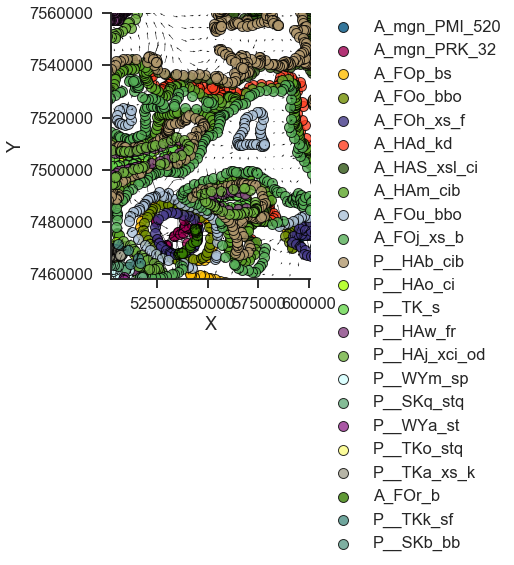

In [44]:
%matplotlib inline
gp.plot.plot_data(geo_model, direction='z');

## Load reprojected topgraphy to model

Cropped raster to geo_model.grid.extent.
[ 502536  600652 7458000 7560000] [115 110]
storing converted file...
Active grids: ['regular' 'topography']
A_mgn_PMI_520
A_mgn_PRK_32
Wyloo_Group
Shingle_Creek_Group
Turee_Creek_Group
Hamersley_Group
Fortescue_Group


,order_series,BottomRelation
A_mgn_PMI_520,1,Erosion
A_mgn_PRK_32,2,Erosion
Wyloo_Group,3,Erosion
Shingle_Creek_Group,4,Erosion
Turee_Creek_Group,5,Erosion
Hamersley_Group,6,Erosion
Fortescue_Group,7,Erosion


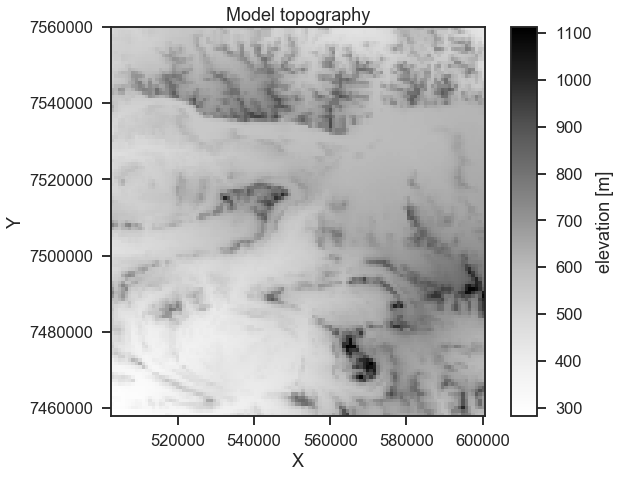

In [45]:
fp = '../test_data3/dtm/hams3_dtm_rp.tif'
geo_model.set_topography(source='gdal',filepath=fp)

## Load stratigraphic Series

f=open('../test_data3/tmp/hams3_groups_clean.csv',"r")
contents =f.readlines()
f.close


faults = gp.Faults()
series = gp.Series(faults)
series.df

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])
groups=[]

for i in range (1,int(ngroups)+1):
    groups.append(contents[i].replace("\n",""))
    series.add_series(contents[i].replace("\n",""))
    print(contents[i].replace("\n",""))

series.delete_series('Default series')

series

## Load surfaces and assign to series

In [46]:
surfaces = gp.Surfaces(series)

#ngroups=5
for i in range(0,ngroups):
    f=open('../test_data3/tmp/'+groups[i]+'.csv',"r")
    contents =f.readlines()
    nformations=str(contents[0])
    nformations=nformations.split(" ")
    nformations=int(nformations[1].replace("\n",""))

    for j in range (1,int(nformations)+1):
        surfaces.add_surface(contents[j].replace("\n",""))
        d={groups[i]:contents[j].replace("\n","")}
        surfaces.map_series({groups[i]:(contents[j].replace("\n",""))}) #working but no gps
        #gp.map_series_to_surfaces(geo_model, {groups[0]:(contents[j].replace("\n",""))},#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX<<<<
              #  set_series=True, remove_unused_series=True)
    f.close

surfaces

,surface,series,order_surfaces,isBasement,color,id
0,A_mgn_PMI_520,A_mgn_PMI_520,1,False,#015482,1
1,A_mgn_PRK_32,A_mgn_PRK_32,1,False,#9f0052,2
2,P__WYm_sp,Wyloo_Group,1,False,#ffbe00,3
3,P__WYa_st,Wyloo_Group,2,False,#728f02,4
4,P__WYd_kd,Wyloo_Group,3,False,#443988,5
5,P__SKq_stq,Shingle_Creek_Group,1,False,#ff3f20,6
6,P__SKb_bb,Shingle_Creek_Group,2,False,#325916,7
7,P__TKa_xs_k,Turee_Creek_Group,1,False,#5DA629,8
8,P__TKo_stq,Turee_Creek_Group,2,False,#acc2d9,9
9,P__TKk_sf,Turee_Creek_Group,3,False,#56ae57,10


## Set Interpolation Data

In [47]:

id_only_one_bool = geo_model.surface_points.df['id'].value_counts() == 1
id_only_one = id_only_one_bool.index[id_only_one_bool]
single_vals = geo_model.surface_points.df[geo_model.surface_points.df['id'].isin(id_only_one)]
for idx, vals in single_vals.iterrows():
    geo_model.add_surface_points(vals['X'], vals['Y'], vals['Z'], vals['surface'])
    
geo_model.update_structure()


,values
isLith,True
isFault,False
number faults,0
number surfaces,23
number series,1
number surfaces per series,[23]
len surfaces surface_points,"[7, 37, 49, 59, 67, 177, 246, 294, 100, 242, 3..."
len series surface_points,[2264]
len series orientations,[663]


In [48]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Compilation Done!


## Provide summary data on model

In [49]:
geo_model.additional_data.structure_data

,values
isLith,True
isFault,False
number faults,0
number surfaces,23
number series,1
number surfaces per series,[23]
len surfaces surface_points,"[7, 37, 49, 59, 67, 177, 246, 294, 100, 242, 3..."
len series surface_points,[2264]
len series orientations,[663]


## Calculate Model

In [50]:


gp.compute_model(geo_model)

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\gempy\core\solution.py:253: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e))



Lithology ids 
  [18. 18. 18. ...  1.  1.  1.] 

## Extract surfaces to visualize in 3D renderers

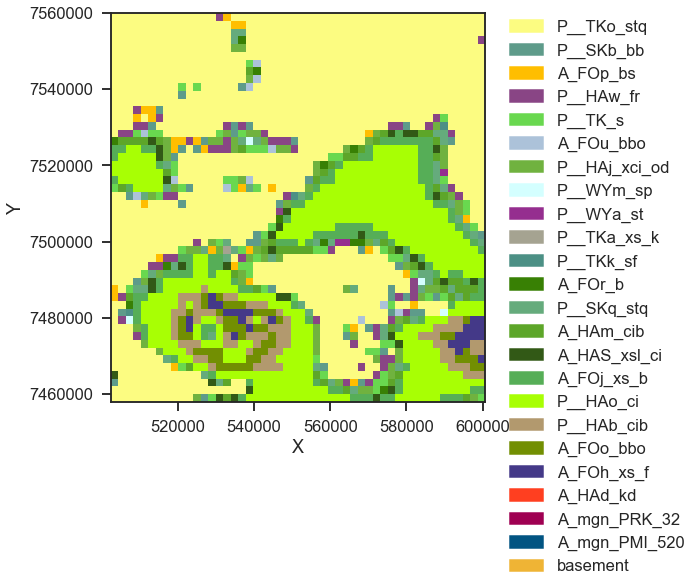

In [51]:
gp.plot.plot_section(geo_model, 49, direction='z', show_data=False)

In [52]:
ver , sim = gp.get_surfaces(geo_model)

import winsound
duration = 300  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)

## Visualise model

In [53]:
gp.plot.plot_3D(geo_model, render_data=False)

closing vtk


In [54]:
from gempy import plot
#gp.plot.export_to_vtk(geo_model, path='./test_data3/vtk/', name='hams3.vtk', voxels=False, block=None, surfaces=True)